In [1]:
import scipy.signal.windows as window
import scipy.interpolate as interp
import numpy as np
from matplotlib import pyplot as plt
from numpy import fft as fft
import h5py
import glob
import scipy.signal as signal
plt.ion()

# Stealing John's load in script
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [2]:
fname='LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5'
Hstrain1,Hdt1,Hutc1=read_file(fname)
fname='LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5'
Hstrain2,Hdt2,Hutc2=read_file(fname)
fname='LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5'
Hstrain3,Hdt3,Hutc3=read_file(fname)
fname='LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5'
Hstrain4,Hdt4,Hutc4=read_file(fname)

In [3]:
fname='LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5'
Lstrain1,Ldt1,Lutc1=read_file(fname)
fname='LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5'
Lstrain2,Ldt2,Lutc2=read_file(fname)
fname='LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5'
Lstrain3,Ldt3,Lutc3=read_file(fname)
fname='LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5'
Lstrain4,Ldt4,Lutc4=read_file(fname)

In [4]:
template_name='LOSC_Event_tutorial/GW170104_4_template.hdf5'
th1,tl1=read_template(template_name)
template_name='LOSC_Event_tutorial/GW150914_4_template.hdf5'
th2,tl2=read_template(template_name)
template_name='LOSC_Event_tutorial/LVT151012_4_template.hdf5'
th3,tl3=read_template(template_name)
template_name='LOSC_Event_tutorial/GW151226_4_template.hdf5'
th4,tl4=read_template(template_name)

In [5]:
H_fft1 = abs(fft.rfft(Hstrain1))
L_fft1 = abs(fft.rfft(Lstrain1))
H_fft2 = abs(fft.rfft(Hstrain2))
L_fft2 = abs(fft.rfft(Lstrain2))
H_fft3 = abs(fft.rfft(Hstrain3))
L_fft3 = abs(fft.rfft(Lstrain3))
H_fft4 = abs(fft.rfft(Hstrain4))
L_fft4 = abs(fft.rfft(Lstrain4))

th_fft1 = abs(fft.rfft(th1))
tl_fft1 = abs(fft.rfft(tl1))
th_fft2 = abs(fft.rfft(th2))
tl_fft2 = abs(fft.rfft(tl2))
th_fft3 = abs(fft.rfft(th3))
tl_fft3 = abs(fft.rfft(tl3))
th_fft4 = abs(fft.rfft(th4))
tl_fft4 = abs(fft.rfft(tl4))

signalsize1 = len(th1)
signalsize2 = len(th2)
signalsize3 = len(th3)
signalsize4 = len(th4)

fVals1=np.arange(start = 0,stop = signalsize1/2+1)/signalsize1/Hdt1
fVals2=np.arange(start = 0,stop = signalsize2/2+1)/signalsize2/Hdt2
fVals3=np.arange(start = 0,stop = signalsize3/2+1)/signalsize3/Hdt3
fVals4=np.arange(start = 0,stop = signalsize4/2+1)/signalsize4/Hdt4


# a) Building our noise model

Okay so as said in class and in the assignment, we want a window that doesn't effect the middle of our signal as to not distort/reduce a detected grav wave chirp and to preserve signal so we have a reference when calculating SNR. However, we still want it to decay to zero at the end. Because of this we'll use a tukey (chopped cosine) window function with a $\alpha$ =  0.3 (70% is flat). Below is an example of how it effects one of our examples. Doesn't hit the bulk of the signal which is great.

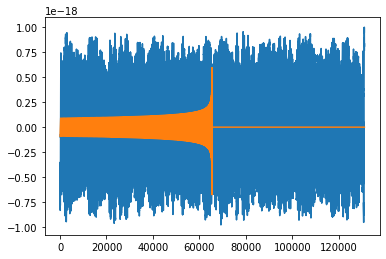

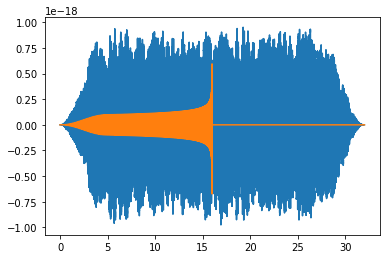

In [6]:
plt.figure(1)
plt.plot(Hstrain1)
plt.plot(th1)

win = window.tukey(signalsize1,alpha=0.3)

plt.figure(2)
plt.plot(Hdt1*range(len(Hstrain1)),win*Hstrain1)
plt.plot(Hdt1*range(len(Hstrain1)),win*th1)

H_fft_win = fft.rfft(win*Hstrain1)
th_fft_win = fft.rfft(win*th1)

Okay up next is filtering. John's technique was averaging based on neighbors. I decided to use Savitzky–Golay filtering cause it's supposed to smooth data without distorting signal tendency. This seemed like a reasonable improvement. I had to careful about selecting parameters because in some cases it would turn values in nans. Not sure why. Anyway looks pretty good here. The PSD for prewhitening is the averaged PSD from all four detection events at the hanford detector to average out grav wave signal.

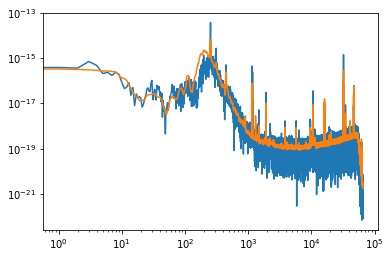

In [7]:
PSD= (abs(H_fft_win)**2 +abs(fft.rfft(win*Hstrain2))**2+abs(fft.rfft(win*Hstrain3))**2+abs(fft.rfft(win*Hstrain4))**2)/4
PSD = signal.savgol_filter(PSD,11,1)
#for i in range(70):
    #PSD=(PSD+np.roll(PSD,1)+np.roll(PSD,-1))/3
H_fft_win1 = H_fft_win/np.sqrt(PSD)
th_fft_win1 = th_fft_win/np.sqrt(PSD)

plt.figure(2)
plt.loglog(abs(H_fft_win))
plt.loglog(np.sqrt(PSD))
#plt.loglog(np.sqrt(Nft))

# Wow look how smooth that data is! Surely it is desrving of extra points...

Okay now we just take the correlation function and see how it did (how high we are above the noise). It looks okay... honestly not that much better than Johns (and this is a different wave then he did in class) but eh I'll take it.

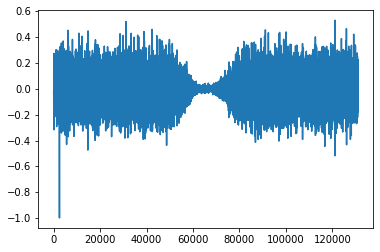

In [8]:
xcorr2=np.fft.irfft(H_fft_win1*np.conj(th_fft_win1))
plt.plot(xcorr2)

Okay lets put this all together in a function

In [9]:
def Nmodel(SignalH,SignalL,TemplateH,TemplateL):
    win = window.tukey(signalsize1,alpha=0.3)
    H_fft_win = fft.rfft(win*SignalH)
    L_fft_win = fft.rfft(win*SignalL)
    th_fft_win = fft.rfft(win*TemplateH)
    tl_fft_win = fft.rfft(win*TemplateL)
    
    PSDH=(abs(fft.rfft(win*Hstrain1))**2 +abs(fft.rfft(win*Hstrain2))**2+abs(fft.rfft(win*Hstrain3))**2+abs(fft.rfft(win*Hstrain4))**2)/4
    PSDH1 = signal.savgol_filter(PSDH,11,1)

    H_fft_win1 = H_fft_win/np.sqrt(PSDH1)
    th_fft_win1 = th_fft_win/np.sqrt(PSDH1)
    
    PSDL=(abs(fft.rfft(win*Lstrain1))**2 +abs(fft.rfft(win*Lstrain2))**2+abs(fft.rfft(win*Lstrain3))**2+abs(fft.rfft(win*Lstrain4))**2)/4
    PSDL1 = signal.savgol_filter(PSDL,11,1)
    L_fft_win1 = L_fft_win/np.sqrt(PSDL1)
    tl_fft_win1 = tl_fft_win/np.sqrt(PSDL1)
    
    xcorrH=np.fft.irfft(H_fft_win1*np.conj(th_fft_win1))
    xcorrL=np.fft.irfft(L_fft_win1*np.conj(tl_fft_win1))
    return(xcorrH,xcorrL,PSDH,PSDL)

# b) Applying noise model

Now we're gonna run our noise model on all the events

Text(0.5, 1.0, 'GW170104')

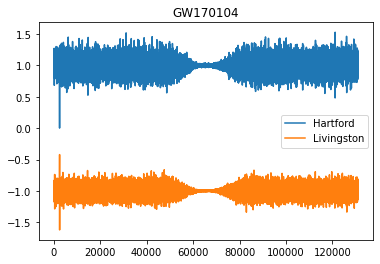

In [10]:
(xcorrH1,xcorrL1,PSDH1,PSDL1) = Nmodel(Hstrain1,Lstrain1,th1,tl1)
plt.plot(xcorrH1+1,label='Hartford')
plt.plot(xcorrL1-1,label='Livingston')
plt.legend()
plt.title('GW170104')


Text(0.5, 1.0, 'GW150914')

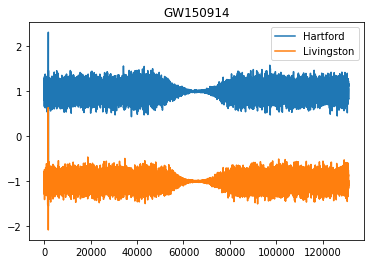

In [11]:
(xcorrH2,xcorrL2,PSDH2,PSDL2) = Nmodel(Hstrain2,Lstrain2,th2,tl2)
plt.plot(xcorrH2+1,label='Hartford')
plt.plot(xcorrL2-1,label='Livingston')
plt.legend()
plt.title('GW150914')

Text(0.5, 1.0, 'LVT151012')

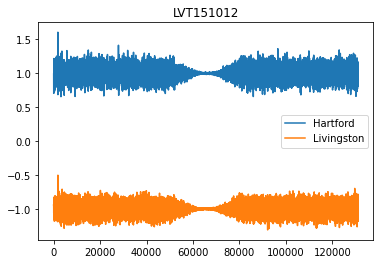

In [12]:
(xcorrH3,xcorrL3,PSDH3,PSDL3) = Nmodel(Hstrain3,Lstrain3,th3,tl3)
plt.plot(xcorrH3+1,label='Hartford')
plt.plot(xcorrL3-1,label='Livingston')
plt.legend()
plt.title('LVT151012')

Text(0.5, 1.0, 'GW151226')

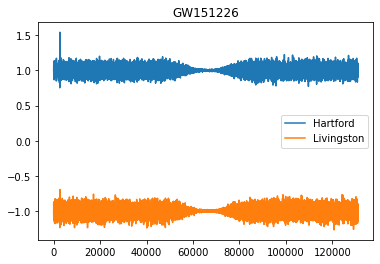

In [13]:
(xcorrH4,xcorrL4,PSDH4,PSDL4) = Nmodel(Hstrain4,Lstrain4,th4,tl4)
plt.plot(xcorrH4+1,label='Hartford')
plt.plot(xcorrL4-1,label='Livingston')
plt.legend()
plt.title('GW151226')


# c) Noise Analysis

We'll take the noise for each event to be the average value of the amplitude spectrum averaged between the two detectors on the basis that the majority of the recieved signal is noise

In [14]:
print('Noise in event GW170104 is',(np.mean(np.sqrt(abs(fft.rfft(win*Hstrain1))**2))+np.mean(np.sqrt(abs(fft.rfft(win*Lstrain1))**2)))/2)
print('Noise in event GW150914 is',(np.mean(np.sqrt(abs(fft.rfft(win*Hstrain2))**2))+np.mean(np.sqrt(abs(fft.rfft(win*Lstrain2))**2)))/2)
print('Noise in event LVT151012 is',(np.mean(np.sqrt(abs(fft.rfft(win*Hstrain3))**2))+np.mean(np.sqrt(abs(fft.rfft(win*Lstrain3))**2)))/2)
print('Noise in event GW151226 is',(np.mean(np.sqrt(abs(fft.rfft(win*Hstrain4))**2))+np.mean(np.sqrt(abs(fft.rfft(win*Lstrain4))**2)))/2)

Noise in event GW170104 is 5.363939179370362e-18
Noise in event GW150914 is 5.093189605408224e-18
Noise in event LVT151012 is 7.561651787528057e-18
Noise in event GW151226 is 6.687749959317918e-18


The SNR will be given by the peak value of the correlated, smoothed template and signal functions divided by the standard deviation of the correlated, smoothed template and signal functions as averaged away from the 'peak' and the reduction due to windowing

In [15]:
SNRH1 = max(abs(xcorrH1))/np.std(xcorrH1[9000:])
SNRL1 = max(abs(xcorrL1))/np.std(xcorrL1[9000:])
SNRH2 = max(abs(xcorrH2))/np.std(xcorrH2[9000:])
SNRL2 = max(abs(xcorrL2))/np.std(xcorrL2[9000:])
SNRH3 = max(abs(xcorrH3))/np.std(xcorrH3[9000:])
SNRL3 = max(abs(xcorrL3))/np.std(xcorrL3[9000:])
SNRH4 = max(abs(xcorrH4))/np.std(xcorrH4[9000:])
SNRL4 = max(abs(xcorrL4))/np.std(xcorrL4[9000:])

print('SNR for event GW170104 Hartford is', SNRH1)
print('SNR for event GW170104 Livingston is', SNRL1)
print('SNR for event GW170104 combined is', SNRH1+SNRL1)

print('\nSNR for event GW150914 Hartford is', SNRH2)
print('SNR for event GW150914 Livingston is', SNRL2)
print('SNR for event GW150914 combined is', SNRH2+SNRL2)

print('\nSNR for event LVT151012 Hartford is', SNRH3)
print('SNR for event LVT151012 Livingston is', SNRL3)
print('SNR for event LVT151012 combined is', SNRH3+SNRL3)

print('\nSNR for event GW151226 Hartford is', SNRH4)
print('SNR for event GW151226 Livingston is', SNRL4)
print('SNR for event GW151226 combined is', SNRH4+SNRL4)



SNR for event GW170104 Hartford is 9.256350788461468
SNR for event GW170104 Livingston is 8.50208781522324
SNR for event GW170104 combined is 17.75843860368471

SNR for event GW150914 Hartford is 19.761414090750037
SNR for event GW150914 Livingston is 13.547606582577576
SNR for event GW150914 combined is 33.30902067332761

SNR for event LVT151012 Hartford is 7.531045875352702
SNR for event LVT151012 Livingston is 7.222504603110644
SNR for event LVT151012 combined is 14.753550478463346

SNR for event GW151226 Hartford is 11.022375715532979
SNR for event GW151226 Livingston is 5.651750410489021
SNR for event GW151226 combined is 16.674126126022


# d) SNR comparison

Okay Rigel if you are marking this I am attempting to do what you explained in your TA session on the thursday which I think was slap the noise onto the template and do the match filter and see how it compares. So that is what I will do

In [16]:
# Okay we are doing the same thing as before, except our "true" signal is just the template convoluted with our noise spectrum
def Nmodel_anal(SignalH,SignalL,TemplateH,TemplateL):
    win = window.tukey(signalsize1,alpha=0.3)
    th_fft_win = abs(fft.rfft(win*TemplateH))
    tl_fft_win = fft.rfft(win*TemplateL)
    
    PSDH=(abs(fft.rfft(win*Hstrain1))**2 +abs(fft.rfft(win*Hstrain2))**2+abs(fft.rfft(win*Hstrain3))**2+abs(fft.rfft(win*Hstrain4))**2)/4
    PSDH1 = signal.savgol_filter(PSDH,11,1)

    th_fft_winsig = np.sqrt(th_fft_win*np.sqrt(PSDH1))/np.sqrt(PSDH1)
    th_fft_wintemp = th_fft_win/np.sqrt(PSDH1)
    
    PSDL=(abs(fft.rfft(win*Lstrain1))**2 +abs(fft.rfft(win*Lstrain2))**2+abs(fft.rfft(win*Lstrain3))**2+abs(fft.rfft(win*Lstrain4))**2)/4
    PSDL1 = signal.savgol_filter(PSDL,11,1)
    
    tl_fft_winsig = np.sqrt(tl_fft_win*np.sqrt(PSDL1))/np.sqrt(PSDL1)
    tl_fft_wintemp = th_fft_win/np.sqrt(PSDL1)
    
    xcorrH=np.fft.irfft(th_fft_winsig*np.conj(th_fft_wintemp))
    xcorrL=np.fft.irfft(tl_fft_winsig*np.conj(tl_fft_wintemp))
    return(xcorrH,xcorrL,PSDH,PSDL)


In [17]:
(AxcorrH1,AxcorrL1,APSDH1,APSDL1) = Nmodel_anal(Hstrain1,Lstrain1,th1,tl1)
(AxcorrH2,AxcorrL2,APSDH2,APSDL2) = Nmodel_anal(Hstrain2,Lstrain2,th2,tl2)
(AxcorrH3,AxcorrL3,APSDH3,APSDL3) = Nmodel_anal(Hstrain3,Lstrain3,th3,tl3)
(AxcorrH4,AxcorrL4,APSDH4,APSDL4) = Nmodel_anal(Hstrain4,Lstrain4,th4,tl4)

In [18]:
ASNRH1 = max(abs(AxcorrH1))/np.std(AxcorrH1[9000:])
ASNRL1 = max(abs(AxcorrL1))/np.std(AxcorrL1[9000:])
ASNRH2 = max(abs(AxcorrH2))/np.std(AxcorrH2[9000:])
ASNRL2 = max(abs(AxcorrL2))/np.std(AxcorrL2[9000:])
ASNRH3 = max(abs(AxcorrH3))/np.std(AxcorrH3[9000:])
ASNRL3 = max(abs(AxcorrL3))/np.std(AxcorrL3[9000:])
ASNRH4 = max(abs(AxcorrH4))/np.std(AxcorrH4[9000:])
ASNRL4 = max(abs(AxcorrL4))/np.std(AxcorrL4[9000:])

print('SNR for event GW170104 Hartford is', ASNRH1)
print('SNR for event GW170104 Livingston is', ASNRL1)
print('SNR for event GW170104 combined is', ASNRH1+ASNRL1)

print('\nSNR for event GW150914 Hartford is', ASNRH2)
print('SNR for event GW150914 Livingston is', ASNRL2)
print('SNR for event GW150914 combined is', ASNRH2+ASNRL2)

print('\nSNR for event LVT151012 Hartford is', ASNRH3)
print('SNR for event LVT151012 Livingston is', ASNRL3)
print('SNR for event LVT151012 combined is', ASNRH3+ASNRL3)

print('\nSNR for event GW151226 Hartford is', ASNRH4)
print('SNR for event GW151226 Livingston is', ASNRL4)
print('SNR for event GW151226 combined is', ASNRH4+ASNRL4)

SNR for event GW170104 Hartford is 162.0172914167638
SNR for event GW170104 Livingston is 86.27636237214939
SNR for event GW170104 combined is 248.29365378891322

SNR for event GW150914 Hartford is 163.07362140812182
SNR for event GW150914 Livingston is 84.79153984241866
SNR for event GW150914 combined is 247.8651612505405

SNR for event LVT151012 Hartford is 155.8412648445063
SNR for event LVT151012 Livingston is 85.29387416063342
SNR for event LVT151012 combined is 241.1351390051397

SNR for event GW151226 Hartford is 164.27972886917328
SNR for event GW151226 Livingston is 91.21809442347855
SNR for event GW151226 combined is 255.49782329265184


Okay well obviously this is way higher SNR than before because our data "noise" and the noise we use for prewhitening are the same so yeah. Idk if I did this right. I think our SNR disagrees ie. is better here because we are comparing the same signal, it's just that one we tried to "hide" with noise which happens to be the same noise we use in whitening so of course the signal seems better.

# e) Noise location

Okay so we are taking the noise model and we are adding all the it cumatively and dividing this new array by the total sum. Where the value crosses is 0.5 is the frequency where 50% of the power (not sure if "weight" is proportional to amplitude or power so I chose power) is above and below. As you can see for the noise model and the H1 template it is quite close, about 8Hz for our noise model and 11 Hz for our template. (also note we have introduced true frequencies in Hz for this part of the analysis, go back to where we first called things in)

Text(0.5, 0, 'Freq (Hz)')

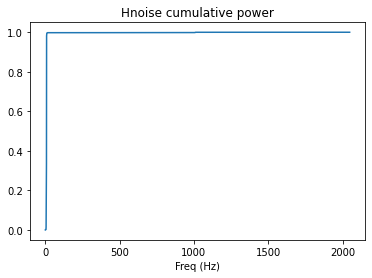

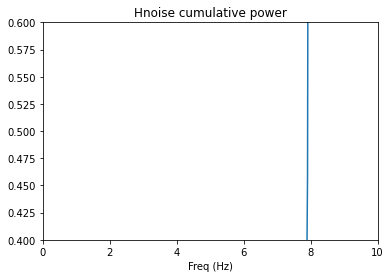

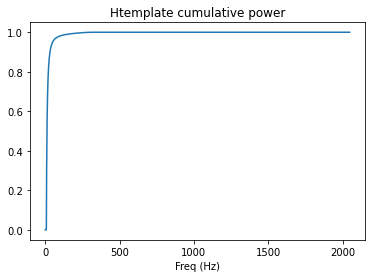

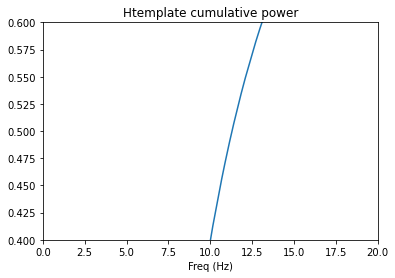

In [19]:
Hnoise = (abs(fft.rfft(win*Hstrain1))**2 +abs(fft.rfft(win*Hstrain2))**2+abs(fft.rfft(win*Hstrain3))**2+abs(fft.rfft(win*Hstrain4))**2)/4
Hsum = np.sum(Hnoise)
Hcsum=np.zeros(len(Hnoise)+1)
Hcsum[0]=0
for i in range(len(Hnoise)):
    Hcsum[i+1]=Hnoise[i]+Hcsum[i]
plt.figure(1)
plt.plot(fVals1,Hcsum[1:]/Hsum)
plt.title('Hnoise cumulative power')
plt.xlabel('Freq (Hz)')

plt.figure(2)
plt.plot(fVals1,Hcsum[1:]/Hsum)
plt.title('Hnoise cumulative power')
plt.ylim([0.4,0.6])
plt.xlim([0,10])
plt.xlabel('Freq (Hz)')

Htemp = th_fft1**2
Hsum = np.sum(Htemp)
Hcsum=np.zeros(len(Htemp)+1)
Hcsum[0]=0
for i in range(len(Htemp)):
    Hcsum[i+1]=Htemp[i]+Hcsum[i]

plt.figure(3)
plt.plot(fVals1,Hcsum[1:]/Hsum)
plt.title('Htemplate cumulative power')
plt.xlabel('Freq (Hz)')

plt.figure(4)
plt.plot(fVals1,Hcsum[1:]/Hsum)
plt.ylim([0.4,0.6])
plt.xlim([0,20])
plt.title('Htemplate cumulative power')
plt.xlabel('Freq (Hz)')


# f) Time of wave

This script will find the time of the max value from the correlation and multiply it by dt to give relative time of arrival

In [20]:
H1t = max(enumerate(xcorrH1), key = lambda x: abs(x[1]))[0]*Hdt1
L1t = max(enumerate(xcorrL1), key = lambda x: abs(x[1]))[0]*Hdt1

H2t = max(enumerate(xcorrH2), key = lambda x: abs(x[1]))[0]*Hdt2
L2t = max(enumerate(xcorrL2), key = lambda x: abs(x[1]))[0]*Hdt2

H3t = max(enumerate(xcorrH3), key = lambda x: abs(x[1]))[0]*Hdt3
L3t = max(enumerate(xcorrL3), key = lambda x: abs(x[1]))[0]*Hdt3

H4t = max(enumerate(xcorrH4), key = lambda x: abs(x[1]))[0]*Hdt4
L4t = max(enumerate(xcorrL4), key = lambda x: abs(x[1]))[0]*Hdt4

In [21]:
print('dt is',Hdt1)
print('time difference between H and L GW170104 is', abs(H1t-L1t),'s')
print('time difference between H and L GW150914 is', abs(H2t-L2t),'s')
print('time difference between H and L LVT151012 is', abs(H3t-L3t),'s')
print('time difference between H and L GW151226 is', abs(H4t-L4t),'s')

dt is 0.000244140625
time difference between H and L GW170104 is 0.004638671875 s
time difference between H and L GW150914 is 0.009033203125 s
time difference between H and L LVT151012 is 0.001953125 s
time difference between H and L GW151226 is 0.000244140625 s


In [22]:
print('expected time difference for 4000km at light speed is',4000000/3e8,'s')

expected time difference for 4000km at light speed is 0.013333333333333334 s


That's very close! Depends on exact distance and direction the waveis coming from. GW151226 might have been perpendicular to the plane intersecting both sites (almost no time difference). Driving distance from Hanford to Livingston is close to 4000km and all so all the time offsets showing < 4000km at light speed is a very good sign. I'm not sure what positional uncertainty we should have, but the time offset should be anywhere from 0 to however long it takes for light to travel the distance between the two detectors.